In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as img
import seaborn as sns
import numpy as np
import scipy
%matplotlib widget

In [2]:
data = scipy.io.loadmat("point_clouds/data.mat")
X, Y = data["X"], data["Y"]

# Sample for lower dimensions
sample = False
if sample:
    np.random.seed(100)
    n = 500
    idx = np.random.choice(X.shape[0], n, replace=False)
    X = X[sorted(idx)]
    Y = Y[sorted(idx)]
    
# Missing data
missing = True
if missing:
    X = X[X[:,0] < -0.023]
    Z = X.copy()
    X = Y
    Y = Z

s = min(X.shape[0], Y.shape[0]) / max(X.shape[0], Y.shape[0])

X_org = X.copy()
Y_org = Y.copy()

Mx = np.ones(X.shape[0])
Mx /= Mx.sum()
My = np.ones(Y.shape[0])
My /= My.sum()
    
print("Missing rate: {}".format(1-s))

X -= X.mean(0)
Y -= Y.mean(0)

Missing rate: 0.4510322922181048


## Plot the original point clouds

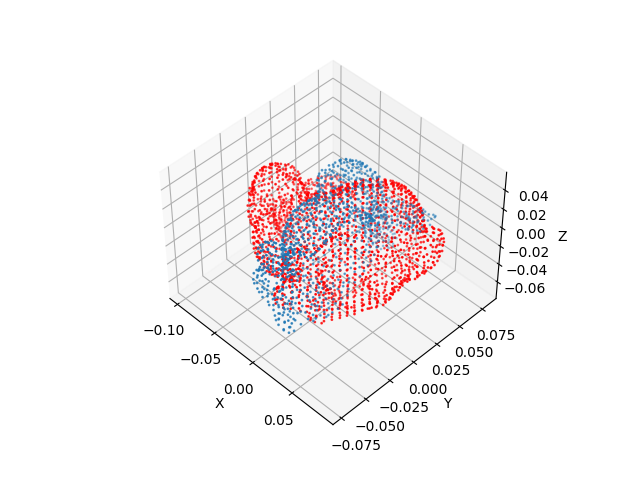

In [3]:
ax = plt.figure().add_subplot(projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], s=1, color="r")
ax.scatter(Y[:, 0], Y[:, 1], Y[:, 2], s=1)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.view_init(elev=45., azim=-45)

plt.show()

## Setting for rigid registration

In [4]:
D = scipy.spatial.distance.cdist(X, Y, 'sqeuclidean')
# D /= D.max()

In [7]:
from pot_solvers.apdagd_mn import apdagd_mn
def unbalanced_OT(X, Y, Mx, My, s, D, params):
    nx, d = X.shape
    ny, d = Y.shape
    preR = np.zeros((d, d), dtype=float)
    R = np.ones((d, d), dtype=float)
    t = 0
    Ytransformed = Y @ R + t
    it = 0
    while True:
        preR = R
        it += 1
        T, _ = apdagd_mn(Mx, 
                         My,
                         D, 
                         s=s, 
                         tol=0.05, verbose=False, print_every=50,
                         check_termination=True, num_iters=500,
                         gamma=params["epsilon"], save_iterates=False,
                         round=False
                        )
        ux = X.T @ T  @ np.ones(ny) / T.sum().sum()
        uy = Y.T @ T.T @ np.ones(nx) / T.sum().sum()
        X_acrid = X - ux.T
        Y_acrid = Y - uy.T
        A = Y_acrid.T @ T.T @ X_acrid
        
        U, _, V = np.linalg.svd(A, full_matrices=False)
        C = np.ones(3)
        C[-1] = np.linalg.det(U @ V.T)
        R = np.dot(U * C, V)
        
        t = ux - R @ uy
        Y_transformed = Y @ R + t
        D = scipy.spatial.distance.cdist(X, Y_transformed, 'sqeuclidean')
        
        error = np.linalg.norm(R - preR, ord="fro")
        print(f"""Iter = {it:-2d}, epsilon = {params["epsilon"]:.2e}, ||R error|| = {error:.2e}""", )
        
        params["epsilon"] = params["epsilon"] * params["AnnealRate"]
        
        if error < params["threshold"]:
            break
            
        if it > 200:
            break
    
    return R, t

In [8]:
params = {
    "epsilon": 3.49e-03, 
    "threshold": 1e-4,
    "AnnealRate": 0.995
}
# s = 0.55
R, t = unbalanced_OT(X, Y, Mx, My, s, D, params)

Iter =  1, epsilon = 3.49e-03, ||R error|| = 2.45e+00
Iter =  2, epsilon = 3.47e-03, ||R error|| = 1.09e-01
Iter =  3, epsilon = 3.46e-03, ||R error|| = 1.23e-01
Iter =  4, epsilon = 3.44e-03, ||R error|| = 1.36e-01
Iter =  5, epsilon = 3.42e-03, ||R error|| = 1.47e-01
Iter =  6, epsilon = 3.40e-03, ||R error|| = 1.55e-01
Iter =  7, epsilon = 3.39e-03, ||R error|| = 1.59e-01
Iter =  8, epsilon = 3.37e-03, ||R error|| = 1.60e-01
Iter =  9, epsilon = 3.35e-03, ||R error|| = 1.59e-01
Iter = 10, epsilon = 3.34e-03, ||R error|| = 1.58e-01
Iter = 11, epsilon = 3.32e-03, ||R error|| = 1.56e-01
Iter = 12, epsilon = 3.30e-03, ||R error|| = 1.54e-01
Iter = 13, epsilon = 3.29e-03, ||R error|| = 1.49e-01
Iter = 14, epsilon = 3.27e-03, ||R error|| = 1.42e-01
Iter = 15, epsilon = 3.25e-03, ||R error|| = 1.31e-01
Iter = 16, epsilon = 3.24e-03, ||R error|| = 1.18e-01
Iter = 17, epsilon = 3.22e-03, ||R error|| = 1.05e-01
Iter = 18, epsilon = 3.20e-03, ||R error|| = 9.16e-02
Iter = 19, epsilon = 3.19e-0

Iter = 152, epsilon = 1.64e-03, ||R error|| = 5.92e-04
Iter = 153, epsilon = 1.63e-03, ||R error|| = 5.65e-04
Iter = 154, epsilon = 1.62e-03, ||R error|| = 5.93e-04
Iter = 155, epsilon = 1.61e-03, ||R error|| = 5.81e-04
Iter = 156, epsilon = 1.60e-03, ||R error|| = 5.99e-04
Iter = 157, epsilon = 1.60e-03, ||R error|| = 5.82e-04
Iter = 158, epsilon = 1.59e-03, ||R error|| = 6.02e-04
Iter = 159, epsilon = 1.58e-03, ||R error|| = 6.02e-04
Iter = 160, epsilon = 1.57e-03, ||R error|| = 6.01e-04
Iter = 161, epsilon = 1.57e-03, ||R error|| = 5.79e-04
Iter = 162, epsilon = 1.56e-03, ||R error|| = 5.99e-04
Iter = 163, epsilon = 1.55e-03, ||R error|| = 6.48e-04
Iter = 164, epsilon = 1.54e-03, ||R error|| = 6.00e-04
Iter = 165, epsilon = 1.53e-03, ||R error|| = 5.89e-04
Iter = 166, epsilon = 1.53e-03, ||R error|| = 5.89e-04
Iter = 167, epsilon = 1.52e-03, ||R error|| = 5.72e-04
Iter = 168, epsilon = 1.51e-03, ||R error|| = 6.16e-04
Iter = 169, epsilon = 1.50e-03, ||R error|| = 5.81e-04
Iter = 170

In [9]:
Y_new = Y @ R + t

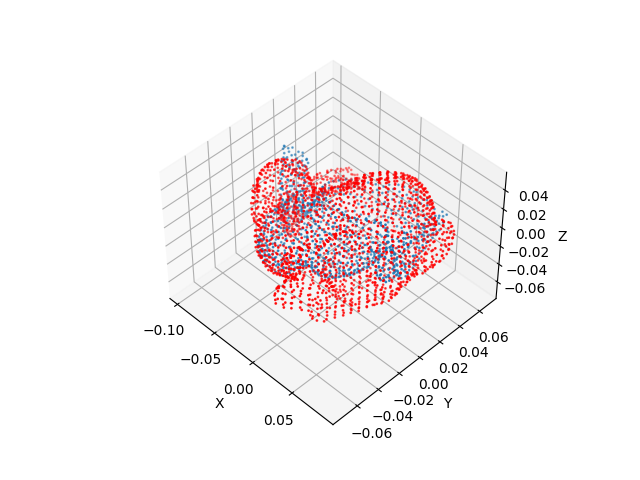

In [10]:
ax = plt.figure().add_subplot(projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], s=1, color="r")
ax.scatter(Y_new[:, 0], Y_new[:, 1], Y_new[:, 2], s=1)
# ax.scatter(Y[:, 0], Y[:, 1], Y[:, 2], s=1)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.view_init(elev=45., azim=-45)

plt.show()

In [11]:
R

array([[ 0.87210884,  0.4482934 ,  0.19611019],
       [-0.47862244,  0.86486218,  0.15143965],
       [-0.10171889, -0.22593459,  0.96881723]])

## Point clouds

In [15]:
import matplotlib.pyplot as plt
import matplotlib.image as img
import seaborn as sns
import numpy as np
import scipy
%matplotlib widget

In [16]:
data = scipy.io.loadmat("point_clouds/data.mat")
X, Y = data["X"], data["Y"]

# Sample for lower dimensions
sample = False
if sample:
    np.random.seed(100)
    n = 500
    idx = np.random.choice(X.shape[0], n, replace=False)
    X = X[sorted(idx)]
    Y = Y[sorted(idx)]
    
# Missing data
missing = True
if missing:
    X = X[X[:,0] < -0.023]
    Z = X.copy()
    X = Y
    Y = Z

m, n = X.shape[0], Y.shape[0]

Mx = np.ones(m) / m
My = np.ones(n) / n
s = min(X.shape[0], Y.shape[0]) / max(X.shape[0], Y.shape[0])
print("Missing rate: {}".format(1-s))

X_org, Y_org = X.copy(), Y.copy()
X_center = np.sum(X / m, 0)
Y_center = np.sum(Y / n, 0)

X = X - X_center
Y = Y - Y_center

D = scipy.spatial.distance.cdist(X, Y, 'sqeuclidean')

Missing rate: 0.4510322922181048


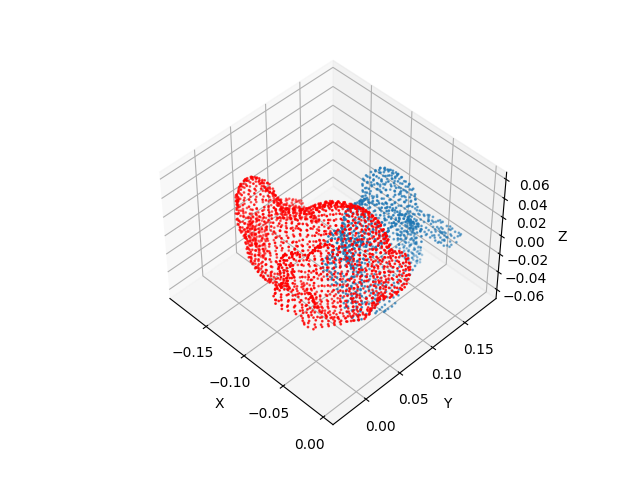

In [17]:
ax = plt.figure().add_subplot(projection='3d')
ax.scatter(X_org[:, 0], X_org[:, 1], X_org[:, 2], s=1, color="r")
ax.scatter(Y_org[:, 0], Y_org[:, 1], Y_org[:, 2], s=1)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.view_init(elev=45., azim=-45)

plt.show()

In [70]:
from pot_solvers.apdagd_mn import apdagd_mn
from pot_solvers.sinkhorn_mn import sinkhorn_mn
from pot_solvers.bregman_proj import bregman_proj
import ot
def unbalanced_OT(X, Y, Mx, My, s, D, params):
    nx, d = X.shape
    ny, d = Y.shape
    preR = np.zeros((d, d), dtype=float)
    R = np.ones((d, d), dtype=float)
    t = 0
    Ytransformed = Y @ R + t
    it = 0
    cost_old = 9999
    while True:
        preR = R
        it += 1
        T, _ = apdagd_mn(Mx, 
                         My,
                         D, 
                         s=s, 
                         tol=0.05, verbose=False, print_every=50,
                         check_termination=True, num_iters=500,
                         gamma=params["epsilon"], save_iterates=False,
                         round=False
                        )

#         T, _ = sinkhorn_mn(Mx, 
#                          My,
#                          D, 
#                          s=s, 
#                          tol=0.05, verbose=False, print_every=50,
#                          check_termination=True, num_iters=500,
#                          gamma=params["epsilon"], save_iterates=False,
#                          round=True
#                         )

#         T = ot.sinkhorn(Mx, My, D, reg=params["epsilon"], numItermax=10000)
        
#         T, cost_old = bregman_proj(Mx, My, D, s, gamma=params["epsilon"], cost_old=cost_old)
    
        ux = X.T @ T  @ np.ones(ny) / T.sum().sum()
        uy = Y.T @ T.T @ np.ones(nx) / T.sum().sum()
        X_acrid = X - ux.T
        Y_acrid = Y - uy.T
        A = Y_acrid.T @ T.T @ X_acrid
        
        U, _, V = np.linalg.svd(A, full_matrices=False)
        C = np.ones(3)
        C[-1] = np.linalg.det(U @ V.T)
        R = np.dot(U * C, V)
        
        t = ux - R @ uy
        Y_transformed = Y @ R + t
        D = scipy.spatial.distance.cdist(X, Y_transformed, 'sqeuclidean')
        
        error = np.linalg.norm(R - preR, ord="fro")
        print(f"""Iter = {it:-2d}, epsilon = {params["epsilon"]:.2e}, ||R error|| = {error:.2e}""", )
        
        params["epsilon"] = params["epsilon"] * params["AnnealRate"]
        
        if error < params["threshold"]:
            break
        
        if it > 200:
            break
    
    return R, t, T

In [71]:
params = {
    "epsilon": 0.004, 
    "threshold": 1e-6,
    "AnnealRate": 0.9
}
R, t, T = unbalanced_OT(X, Y, Mx, My, s, D, params)

KeyboardInterrupt: 

In [ ]:
t = t + X_center - Y_center @ R
Y_new = Y_org @ R + t

In [ ]:
%matplotlib widget
ax = plt.figure().add_subplot(projection='3d')
ax.scatter(X_org[:, 0], X_org[:, 1], X_org[:, 2], s=1, color="r")
ax.scatter(Y_new[:, 0], Y_new[:, 1], Y_new[:, 2], s=1)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.view_init(elev=45., azim=-45)

plt.show()

In [101]:
result_np = {"T": T, "R": R, "t": t}
scipy.io.savemat("/Users/joshnguyen/dev/mmpot/pointcloud_missing_sinkhorn_1e6.mat", result_np)

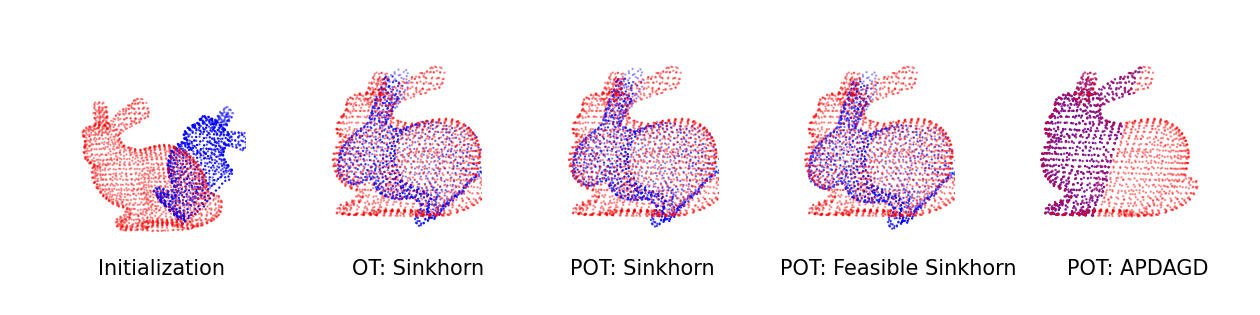

In [59]:
%matplotlib inline

fig = plt.figure(figsize=(16, 4.2))
size = 0.5

ax=plt.subplot(151, projection="3d")
ax.scatter(X_org[:, 0], X_org[:, 1], X_org[:, 2], s=size, color="r", alpha=0.4)
ax.scatter(Y_org[:, 0], Y_org[:, 1], Y_org[:, 2], s=size, color="b")
ax.view_init(elev=94., azim=-45)
ax.set_axis_off()
fig.text(x=0.22, y=0.23, s="Initialization", size=15, ha="center", va="center")

ax=plt.subplot(152, projection="3d")
result = scipy.io.loadmat("/Users/joshnguyen/dev/mmpot/pointcloud_missing_ot_sinkhorn_1e3.mat")
R, t = result["R"], result["t"]
Y_new = Y_org @ R + t
ax.scatter(X_org[:, 0], X_org[:, 1], X_org[:, 2], s=size, color="r", alpha=0.4)
ax.scatter(Y_new[:, 0], Y_new[:, 1], Y_new[:, 2], s=size, color="b")
ax.view_init(elev=90., azim=-30)
ax.set_axis_off()
fig.text(x=0.38, y=0.23, s="OT: Sinkhorn", size=15, ha="center", va="center")


ax=plt.subplot(153, projection="3d")
result = scipy.io.loadmat("/Users/joshnguyen/dev/mmpot/pointcloud_missing_sinkhorn_pot_infeasible_1e6.mat")
R, t = result["R"], result["t"]
Y_new = Y_org @ R + t
ax.scatter(X_org[:, 0], X_org[:, 1], X_org[:, 2], s=size, color="r", alpha=0.4)
ax.scatter(Y_new[:, 0], Y_new[:, 1], Y_new[:, 2], s=size, color="b")
ax.view_init(elev=90., azim=-30)
ax.set_axis_off()
fig.text(x=0.52, y=0.23, s="POT: Sinkhorn", size=15, ha="center", va="center")

ax=plt.subplot(154, projection="3d")
result = scipy.io.loadmat("/Users/joshnguyen/dev/mmpot/pointcloud_missing_sinkhorn_pot_feasible_1e6.mat")
R, t = result["R"], result["t"]
Y_new = Y_org @ R + t
ax.scatter(X_org[:, 0], X_org[:, 1], X_org[:, 2], s=size, color="r", alpha=0.4)
ax.scatter(Y_new[:, 0], Y_new[:, 1], Y_new[:, 2], s=size, color="b")
ax.view_init(elev=90., azim=-30)
fig.text(x=0.68, y=0.23, s="POT: Feasible Sinkhorn", size=15, ha="center", va="center")
ax.set_axis_off()


ax=plt.subplot(155, projection="3d")
result = scipy.io.loadmat("/Users/joshnguyen/dev/mmpot/pointcloud_missing_apdagd_1e6.mat")
R, t = result["R"], result["t"]
Y_new = Y_org @ R + t
ax.scatter(X_org[:, 0], X_org[:, 1], X_org[:, 2], s=size, color="r", alpha=0.4)
ax.scatter(Y_new[:, 0], Y_new[:, 1], Y_new[:, 2], s=size, color="b")
ax.view_init(elev=90., azim=-30)
fig.text(x=0.83, y=0.23, s="POT: APDAGD", size=15, ha="center", va="center")
ax.set_axis_off()

plt.subplots_adjust(wspace=-0.2, hspace=None)

# plt.savefig("figures/point_clouds.pdf", bbox_inches="tight")

plt.show()

In [15]:
result_matlab = scipy.io.loadmat("/Users/joshnguyen/dev/RPOT/result_missing.mat")

In [16]:
T_matlab = result_matlab["T"]

In [17]:
np.linalg.norm(T - T_matlab, ord="fro")

0.0005951641011186878

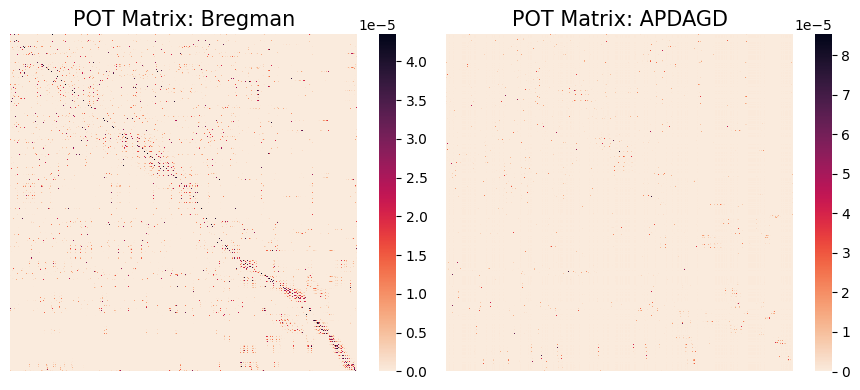

In [39]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(9, 4))
cmap = sns.color_palette("rocket_r", as_cmap=True)
ax = axes[0]
sns.heatmap(T, ax=ax, cmap=cmap)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title(f"POT Matrix: Bregman", size=15)
fig.tight_layout()

ax = axes[1]
sns.heatmap(T_apdagd, ax=ax, cmap=cmap)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title(f"POT Matrix: APDAGD", size=15)
fig.tight_layout()

plt.show()
plt.close(fig)

In [41]:
(T * D).sum()

0.0015917539052807802

In [42]:
(T_apdagd * D).sum()

0.0036186269580799693

## New

In [83]:
from pot_solvers.sinkhorn_mn import sinkhorn_mn
def unbalanced_OT(X, Y, Mx, My, s, D, params):
    nx, d = X.shape
    ny, d = Y.shape
    preR = np.zeros((d, d), dtype=float)
    R = np.ones((d, d), dtype=float)
    t = 0
    Ytransformed = Y @ R + t
    it = 0
    cost_old = 9999
    while True:
        preR = R
        it += 1
        T, logs = sinkhorn_mn(Mx,
                              My,
                              D,
                              s=s,
                              tol=0.05, verbose=False, print_every=50,
                              check_termination=True, num_iters=500,
                              gamma=params["epsilon"], save_iterates=False,
                              round=False, feasible=True, A_mult=1.01
                              )

        ux = X.T @ T @ np.ones(ny) / T.sum().sum()
        uy = Y.T @ T.T @ np.ones(nx) / T.sum().sum()
        X_acrid = X - ux.T
        Y_acrid = Y - uy.T
        A = Y_acrid.T @ T.T @ X_acrid

        U, _, V = np.linalg.svd(A, full_matrices=False)
        C = np.ones(3)
        C[-1] = np.linalg.det(U @ V.T)
        R = np.dot(U * C, V)

        t = ux - R @ uy
        Y_transformed = Y @ R + t
        D = scipy.spatial.distance.cdist(X, Y_transformed, 'sqeuclidean')

        error = np.linalg.norm(R - preR, ord="fro")
        print(f"""Iter = {it:-2d}, epsilon = {params["epsilon"]:.2e}, ||R error|| = {error:.2e}""", )

        params["epsilon"] = params["epsilon"] * params["AnnealRate"]

        if error < params["threshold"]:
            break

        if it > 200:
            break

    return R, t, T


In [84]:
params = {
    "epsilon": 3.49e-03, 
    "threshold": 1e-4,
    "AnnealRate": 0.995
}
s = 0.55
R, t, T = unbalanced_OT(X, Y, Mx, My, s, D, params)

Iter =  1, epsilon = 3.49e-03, ||R error|| = 2.45e+00
Iter =  2, epsilon = 3.47e-03, ||R error|| = 1.24e-01
Iter =  3, epsilon = 3.46e-03, ||R error|| = 1.44e-01
Iter =  4, epsilon = 3.44e-03, ||R error|| = 1.64e-01
Iter =  5, epsilon = 3.42e-03, ||R error|| = 1.82e-01
Iter =  6, epsilon = 3.40e-03, ||R error|| = 1.95e-01
Iter =  7, epsilon = 3.39e-03, ||R error|| = 2.05e-01
Iter =  8, epsilon = 3.37e-03, ||R error|| = 2.10e-01
Iter =  9, epsilon = 3.35e-03, ||R error|| = 2.09e-01
Iter = 10, epsilon = 3.34e-03, ||R error|| = 2.01e-01
Iter = 11, epsilon = 3.32e-03, ||R error|| = 1.85e-01
Iter = 12, epsilon = 3.30e-03, ||R error|| = 1.64e-01
Iter = 13, epsilon = 3.29e-03, ||R error|| = 1.40e-01
Iter = 14, epsilon = 3.27e-03, ||R error|| = 1.16e-01
Iter = 15, epsilon = 3.25e-03, ||R error|| = 9.59e-02
Iter = 16, epsilon = 3.24e-03, ||R error|| = 7.90e-02
Iter = 17, epsilon = 3.22e-03, ||R error|| = 6.56e-02
Iter = 18, epsilon = 3.20e-03, ||R error|| = 5.49e-02
Iter = 19, epsilon = 3.19e-0

Iter = 155, epsilon = 1.61e-03, ||R error|| = 9.01e-04
Iter = 156, epsilon = 1.60e-03, ||R error|| = 9.02e-04
Iter = 157, epsilon = 1.60e-03, ||R error|| = 9.03e-04
Iter = 158, epsilon = 1.59e-03, ||R error|| = 9.03e-04
Iter = 159, epsilon = 1.58e-03, ||R error|| = 9.04e-04
Iter = 160, epsilon = 1.57e-03, ||R error|| = 9.05e-04
Iter = 161, epsilon = 1.57e-03, ||R error|| = 9.06e-04
Iter = 162, epsilon = 1.56e-03, ||R error|| = 9.07e-04
Iter = 163, epsilon = 1.55e-03, ||R error|| = 9.07e-04
Iter = 164, epsilon = 1.54e-03, ||R error|| = 9.08e-04
Iter = 165, epsilon = 1.53e-03, ||R error|| = 9.09e-04
Iter = 166, epsilon = 1.53e-03, ||R error|| = 9.09e-04
Iter = 167, epsilon = 1.52e-03, ||R error|| = 9.10e-04
Iter = 168, epsilon = 1.51e-03, ||R error|| = 9.11e-04
Iter = 169, epsilon = 1.50e-03, ||R error|| = 9.11e-04
Iter = 170, epsilon = 1.50e-03, ||R error|| = 9.12e-04
Iter = 171, epsilon = 1.49e-03, ||R error|| = 9.12e-04
Iter = 172, epsilon = 1.48e-03, ||R error|| = 9.12e-04
Iter = 173

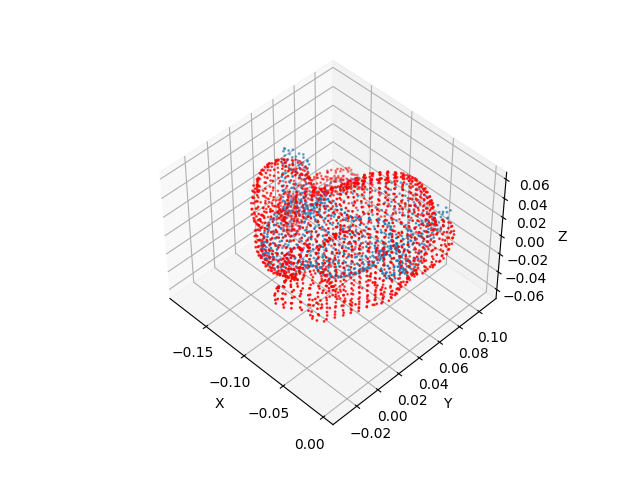

In [85]:
t = t + X_center - Y_center @ R
Y_new = Y_org @ R + t

%matplotlib widget
ax = plt.figure().add_subplot(projection='3d')
ax.scatter(X_org[:, 0], X_org[:, 1], X_org[:, 2], s=1, color="r")
ax.scatter(Y_new[:, 0], Y_new[:, 1], Y_new[:, 2], s=1)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.view_init(elev=45., azim=-45)

plt.show()

In [58]:
result_np = {"T": T, "R": R, "t": t}
scipy.io.savemat("/Users/joshnguyen/dev/mmpot/pointcloud_missing_sinkhorn_pot_infeasible_1e6.mat", result_np)